In [69]:
# base_dir = '/content/drive/MyDrive/CS760-project'
base_dir = '.'

import warnings
warnings.simplefilter('ignore')

# Imports

In [70]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [71]:
# torch

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
# from torch.utils.data import DataLoader

import os
import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
# from torchvision.transforms import ToTensor
import torchvision.transforms as T
from torch.utils.data import random_split
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from PIL import Image


import torch.nn as nn
import torch.nn.functional as F

import gensim
import gensim.downloader

In [72]:
from vanilla_cnn import CNN as softmax_cnn

In [73]:
# default font
plt.rcParams['font.size'] = 10

# default graph size
plt.rcParams['figure.figsize'] = (4,4)

# default graph grid
# plt.rcParams['axes.grid'] = True

# numpy precision
np.set_printoptions(suppress=True, precision=5)

# GPU Support

In [74]:
# device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data Preparation

In [79]:
# pathes to image dataset
#data_dir_path = '/home/yohei/project/cs760/tiny-imagenet-200'
data_dir_path = 'D:/tiny-imagenet-200'

# flag to determine if embedding matrix should be loaded or generated
embedding_pretrained = False

# random data augmentation
def data_transform():
    return T.Compose([
        T.Resize(64),
        T.ColorJitter(brightness=0.3),
        T.RandomAffine(degrees=45, translate=(0.08,0.08), scale=(0.8,1.2), shear=10),
        T.RandomHorizontalFlip(),
        #T.RandomResizedCrop(64,scale=(0.7, 1.4)),
        T.ToTensor(),
    ])

# collect image filenames and associating labels
def format_val():
    val_dir = data_dir_path + '/val'
    print("Formatting: {}".format(val_dir))
    val_annotations = "{}/val_annotations.txt".format(val_dir)
    val_dict = {}
    with open(val_annotations, 'r') as f:
        for line in f:
            line = line.strip().split()
            assert(len(line) == 6)
            wnind = line[1]
            img_name = line[0]
            boxes = '\t'.join(line[2:])
            if wnind not in val_dict:
                val_dict[wnind] = []
            entries = val_dict[wnind]
            entries.append((img_name, boxes))
    assert(len(val_dict) == 200)
    for wnind, entries in val_dict.items():
        val_wnind_dir = "{}/{}".format(val_dir, wnind)
        val_images_dir = "{}/images".format(val_dir)
        val_wnind_images_dir = "{}/images".format(val_wnind_dir)
        os.mkdir(val_wnind_dir)
        os.mkdir(val_wnind_images_dir)
        wnind_boxes = "{}/{}_boxes.txt".format(val_wnind_dir, wnind)
        f = open(wnind_boxes, "w")
        for img_name, box in entries:
            source = "{}/{}".format(val_images_dir, img_name)
            dst = "{}/{}".format(val_wnind_images_dir, img_name)
            os.system("cp {} {}".format(source, dst))
            f.write(img_name+'\\'+box+'\\'+'n')
        f.close()
    print("Formatting val done")
    
    
# create dataset objects with transofrmations only applied to training data
train_dataset = ImageFolder(data_dir_path + '/train', transform=data_transform())
test_dataset = ImageFolder(data_dir_path + '/test', transform=T.ToTensor())

# download pertrained word2vec model using the Gensim API
pretrain_wv = gensim.downloader.load('glove-wiki-gigaword-50')

# Texting label (only one time run at the beginning)
d = {}

f = open(data_dir_path+'/words.txt','r') 
while(1):
    try:
        key, val = f.readline().split("\t")
        d[key] = val[:-1]
    except Exception:
        break

# initialize embedded matrix
matrix = np.zeros((200,50))
not_in_set = []

# Fill embedding matrix with vectors for training class labels
for i in range(len(train_dataset.classes)):
    all_label_terms = d[train_dataset.classes[i]].split(', ')
    num_words = 0
    for j, label_terms in enumerate(all_label_terms):
        # standardize label strings
        label_terms = label_terms.replace('-','')
        label_terms = label_terms.replace('\'','')
        label_terms = label_terms.lower().replace(' ','_')
        if j == 0:
            train_dataset.classes[i] = label_terms
            
        if not embedding_pretrained:
            try:
                if '_' in label_terms:
                    label_split = label_terms.split('_')
                    for lab in label_split:
                        matrix[i] += pretrain_wv[lab]
                        num_words += 1
                else:
                    matrix[i] += pretrain_wv[str(label_terms)]
                    num_words += 1
            except KeyError:
                not_in_set.append(label_terms)

# save embedding matrix
if not embedding_pretrained:
    matrix = np.reshape(matrix,(200*50))
    np.save('embeddings.npy', matrix)
    
# load embedding matrix and normalize
embeddings = torch.from_numpy(np.load('embeddings.npy').reshape(200,50)).to(device)
#embeddings = nn.functional.normalize(embeddings,dim=1)

In [80]:
random_seed = 4
torch.manual_seed(random_seed);

# split data into training and validation sets using stratification
targets = np.array(train_dataset.targets)
train_ind, temp_ind = train_test_split(np.arange(len(targets)),test_size=0.4,shuffle=True,stratify=targets)
test_ind, val_ind = train_test_split(temp_ind,test_size=0.5,stratify=targets[temp_ind])

# create random sampler objects to help with optimization
train_sampler = data.SubsetRandomSampler(train_ind)
val_sampler = data.SubsetRandomSampler(val_ind)

# display number of images in the training and validation sets
len(train_ind), len(val_ind)

(60000, 20000)

In [81]:
# get some examples of closest embedding vector given test word
def test_embedding(word):
    test = torch.tensor(pretrain_wv[str(word)])
    test = torch.reshape(test,(1,50))
    sim = nn.functional.cosine_similarity(embeddings,test,dim=1)
    ind = np.argmax(sim.numpy())
    return train_dataset.classes[ind]

print('Closest training class to shoe:',test_embedding('shoe'))
print('Closest training class to beef:',test_embedding('beef'))
print('Closest training class to child:',test_embedding('child'))

Closest training class to shoe: miniskirt
Closest training class to beef: meat_loaf
Closest training class to child: school_bus


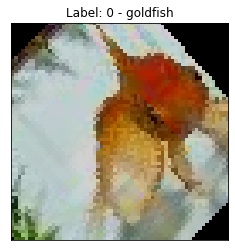

In [82]:
# visualize example of data augmentations
def show_example(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title('Label: '+str(label)+' - '+train_dataset.classes[label])
    plt.yticks([])
    plt.xticks([])
    
show_example(*train_dataset[101])

## Embedding Lookup

In [83]:
# count the number of times the true label is in the top 'n' of the predicted labels
def count_similar(outputs, labels, n=10):
    count = 0

    for output, label in zip(outputs, labels):
        sim_results = []
        label = label.item()

        sim_results = nn.functional.cosine_similarity(embeddings,torch.reshape(output,(1,50)),dim=1)
        sim_results = sim_results.detach().numpy()

        # get n largest results
        max_n_index = np.array(sim_results).argsort()[-n:][::-1]

        # increment count in true label is in top n results
        if label in max_n_index:
            count = count + 1
    return count

# return the top 'n' most similar labels using cosine similarity
def get_labels(outputs, n=10):
    labels = []
    for k, output in enumerate(outputs):
        temp = []
        
        sim_results = nn.functional.cosine_similarity(embeddings,torch.reshape(output,(1,50)),dim=1)
        sim_results = sim_results.detach().numpy()

        # get n largest results
        max_n_index = np.array(sim_results).argsort()[-n:][::-1]
        for j, ind in enumerate(max_n_index):
            temp.append(train_dataset.classes[ind])
        labels.append(temp)
    return labels
    

## Model Fitting

In [84]:
# fit method used for model training
def fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
    
    n = 5
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        # learning rate decay
        if (epoch+1) % (num_epochs/4) == 0:
            for parm in optimizer.param_groups:
                parm['lr'] /= 3.16   # sqrt(10)
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        #訓練フェーズ: training phase
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            
            # 勾配の初期化: initalize the gradient
            optimizer.zero_grad()
            
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算: calc output
            outputs = net(inputs)

            # 損失計算: calc loss
            size = outputs.shape[0]
        
            # get indices of true word embedding vectors
            true_embedding = torch.index_select(embeddings, 0, labels)
            
            # get indices of random false word embedding vectors
            rand_ind = torch.randperm(200).to(device)
            rand_ind = [x for x in rand_ind if x not in labels]
            labels_random = torch.tensor(rand_ind[:size]).to(device)
            false_embedding = torch.index_select(embeddings, 0, labels_random)
            
            # combine true and false embedding vectors using a 1 to denote true and -1 to denote false
            output_stack = torch.vstack((outputs,outputs))
            embeddings_stack = torch.vstack((true_embedding,false_embedding))
            sim_stack = torch.vstack((torch.ones(size),-1*torch.ones(size))).reshape(size*2,)
            
            loss = criterion(output_stack, embeddings_stack, sim_stack)
            train_loss += torch.sum(loss).item()

            # 勾配計算: calc gradient
            loss.backward()

            # パラメータ修正: parameter 
            optimizer.step()
            
            train_acc += count_similar(outputs, labels, n)

        #予測フェーズ: test phase
        net.eval()
        count = 0

        for inputs, labels in val_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算: calc prediction
            outputs = net(inputs)

            # 損失計算: calc loss
            size = outputs.shape[0]
        
            true_embedding = torch.index_select(embeddings, 0, labels)
            rand_ind = torch.randperm(200).to(device)
            rand_ind = [x for x in rand_ind if x not in labels]
            labels_random = torch.tensor(rand_ind[:size]).to(device)
            false_embedding = torch.index_select(embeddings, 0, labels_random)
            
            output_stack = torch.vstack((outputs,outputs))
            embeddings_stack = torch.vstack((true_embedding,false_embedding))
            sim_stack = torch.vstack((torch.ones(size),-1*torch.ones(size))).reshape(size*2,)
            
            loss = criterion(output_stack, embeddings_stack, sim_stack)
            val_loss += torch.sum(loss).item()
            
            val_acc += count_similar(outputs, labels, n)
        
        avg_train_loss = train_loss/len(train_ind)
        avg_train_acc = train_acc/len(train_ind)
        avg_val_loss = val_loss/len(val_ind)
        avg_val_acc = val_acc/len(val_ind)
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

## Model Performance

In [85]:
# helper method to show learning curve
def evaluate_history(history):
    #損失と精度の確認: loss and accuracy
    print(f'Initial: loss: {history[0,3]:.5f} accuracy: {history[0,4]:.5f}') 
    print(f'Final: loss: {history[-1,3]:.5f} accuracy: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 5

    # 学習曲線の表示 (損失): learning curve (loss)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='Training')
    plt.plot(history[:,0], history[:,3], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Loss')
    plt.title('Learning Curve (Loss)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度): learning curve (accuracy)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='Training')
    plt.plot(history[:,0], history[:,4], 'k', label='Test(Val)')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('# of recursion')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.legend()
    plt.show()

##  Show Images and Corresponding Labels

In [86]:
# show input batch of augmented images with the corresponding label 
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 20)

    if net is not None:
      # デバイスの割り当て
        inputs = images.to(device)
        labels = labels.to(device)

      # 予測計算
        outputs = net(inputs)
        predicted = get_labels(outputs, 10)
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(4, 5, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
            predicted_name = predicted[i][0]
          # 正解かどうかで色分けをする
            if label_name in predicted[i][0:5]:
                c = 'green'
            else:
                c = 'blue'
            ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
            ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [87]:
# set PyTorch parameters and seed
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

## Data Pipelines

In [88]:
# size of batch
batch_size = 64

# DataLoarder of Training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

# DataLoarder of Validation data
val_loader = DataLoader(train_dataset,  batch_size=batch_size, sampler=val_sampler)

# DataLoader of Testing Data
test_loader = DataLoader(test_dataset, batch_size=batch_size)

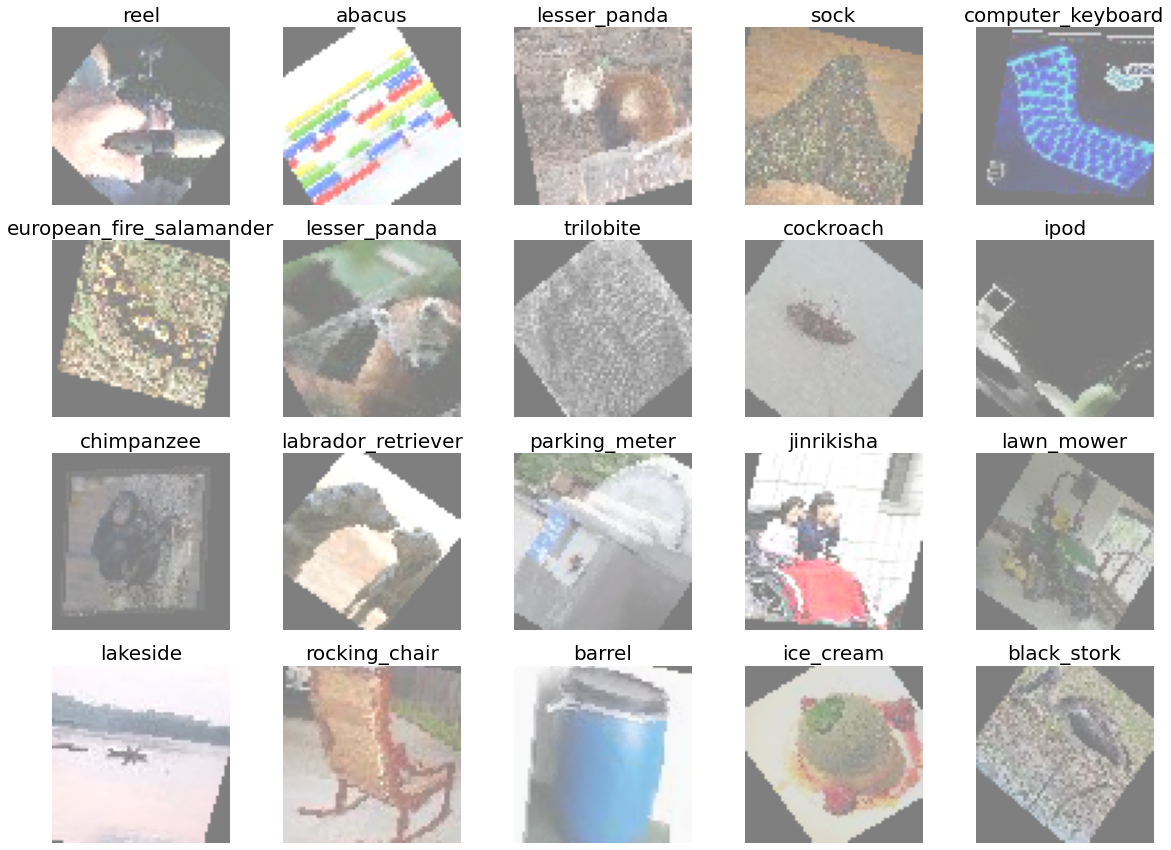

In [89]:
# get the class labels for the training dataset
classes = train_dataset.classes

# 検証データ最初の50個の表示
show_images_labels(train_loader, classes, None, None)

# Def Model

### Parameters

In [90]:
# number of nodes needed at output of fully connected layer
n_output = 50 

# number of nodes of hidden layer
n_hidden = 1024

print(f'num hidden nodes: {n_hidden}   num output nodes: {n_output}')

num hidden nodes: 1024   num output nodes: 50


### Loss Function

In [91]:
# custom loss function described in the DeViSE paper
# invovles using hinge loss with customizable margin
class deviseLoss(nn.Module):
    def __init__(self):
        super(deviseLoss, self).__init__()
        self.margin = torch.tensor(.1, dtype=float).to(device)

    def forward(self, outputs, labels):

        size = outputs.shape[0]
        loss = torch.zeros(size, dtype=float).to(device)

        # get embeddings of true labels
        true_labels_embedding = torch.index_select(embeddings, 0, labels)
        x_mul = torch.mul(nn.functional.normalize(outputs), true_labels_embedding)
        predict_true_similarity = torch.mean(x_mul, dim=1)
        
        # get embeddings of random false labels
        rand_ind = torch.randperm(200).to(device)
        rand_ind = [x for x in rand_ind if x not in labels]
        labels_random = torch.tensor(rand_ind[:size]).to(device)
        false_labels_embedding = torch.index_select(embeddings, 0, labels_random)
        y_mul = torch.mul(nn.functional.normalize(outputs), false_labels_embedding)
        predict_negative_similarity = torch.mean(y_mul, dim=1)

        temp = torch.max((self.margin - predict_true_similarity + predict_negative_similarity),
                          torch.tensor(0.0, dtype=float).to(device))
        loss += temp
        loss = torch.sum(loss)
        return loss

### CNN Model

In [92]:
# module object used to define our Visual-Semantic model
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.5)
        self.l1 = nn.Linear(2048, n_hidden) # 16*32*32
        self.l2 = nn.Linear(n_hidden, n_hidden)
        self.l3 = nn.Linear(n_hidden, n_output)
        
        self.features = nn.Sequential(
            
            self.conv1,
            self.relu,
            self.maxpool,
            
            self.conv2,
            self.relu,
            self.bn2,
            self.maxpool,
            self.dropout1,
            
            self.conv3,
            self.relu,
            self.bn3,
            self.maxpool,
            self.dropout1,

        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout2,
            self.l2,
            self.relu,
            self.l3,
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

### Create model instance

In [93]:
# init randam, 乱数初期化
torch_seed()

# create model instance
net = CNN(n_output, n_hidden).to(device)

# show model summary
summary(net,(batch_size,3,64,64),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [64, 32, 8, 8]            8,272
├─Conv2d: 1-2                            [64, 16, 64, 64]          1,216
├─ReLU: 1-3                              [64, 16, 64, 64]          --
├─MaxPool2d: 1-4                         [64, 16, 32, 32]          --
├─Conv2d: 1-5                            [64, 16, 32, 32]          2,320
├─ReLU: 1-6                              [64, 16, 32, 32]          --
├─BatchNorm2d: 1-7                       [64, 16, 32, 32]          32
├─MaxPool2d: 1-8                         [64, 16, 16, 16]          --
├─Dropout: 1-9                           [64, 16, 16, 16]          --
├─Conv2d: 1-10                           [64, 32, 16, 16]          4,640
├─ReLU: 1-11                             [64, 32, 16, 16]          --
├─BatchNorm2d: 1-12                      [64, 32, 16, 16]          64
├─M

In [21]:
# define loss function. found best results using cosine embedding loss instead of custom hinge loss
criterion = nn.CosineEmbeddingLoss(margin=0.5, reduction='sum')
#criterion = deviseLoss().to(device)

# learning step 学習率
lr = 1e-3

# define optimizer. DeViSE paper used SGD but we have turned to Adam for faster convergence
optimizer = optim.Adam(net.parameters(),lr=lr)
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# number of epock 繰り返し回数
num_epochs = 100

# output 評価結果記録用
history = np.zeros((0,5))

# learning: 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/100], loss: 0.65327 acc: 0.06362 val_loss: 0.64499, val_acc: 0.08085


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/100], loss: 0.63191 acc: 0.10632 val_loss: 0.62303, val_acc: 0.12240


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.61991 acc: 0.13273 val_loss: 0.61146, val_acc: 0.15015


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.61167 acc: 0.15597 val_loss: 0.61570, val_acc: 0.15600


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.60428 acc: 0.17632 val_loss: 0.60485, val_acc: 0.17890


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.59896 acc: 0.18952 val_loss: 0.59964, val_acc: 0.19215


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.59352 acc: 0.20415 val_loss: 0.59662, val_acc: 0.21350


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.58937 acc: 0.21413 val_loss: 0.60835, val_acc: 0.20055


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.58506 acc: 0.22540 val_loss: 0.60154, val_acc: 0.20315


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.58108 acc: 0.23512 val_loss: 0.58473, val_acc: 0.23530


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.57886 acc: 0.24237 val_loss: 0.57363, val_acc: 0.25310


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.57589 acc: 0.24838 val_loss: 0.58785, val_acc: 0.22665


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.57269 acc: 0.25742 val_loss: 0.57499, val_acc: 0.25340


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.56990 acc: 0.26113 val_loss: 0.57163, val_acc: 0.25420


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.56798 acc: 0.26637 val_loss: 0.59122, val_acc: 0.22610


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.56561 acc: 0.27313 val_loss: 0.57958, val_acc: 0.25860


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.56394 acc: 0.27395 val_loss: 0.57486, val_acc: 0.26520


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.56249 acc: 0.27868 val_loss: 0.57407, val_acc: 0.26205


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.56003 acc: 0.28358 val_loss: 0.58229, val_acc: 0.25690


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.55813 acc: 0.28788 val_loss: 0.56026, val_acc: 0.28200


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.55655 acc: 0.29163 val_loss: 0.56683, val_acc: 0.27390


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.55534 acc: 0.29590 val_loss: 0.56585, val_acc: 0.27850


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.55325 acc: 0.30073 val_loss: 0.56784, val_acc: 0.27310


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.55238 acc: 0.30050 val_loss: 0.56339, val_acc: 0.28025


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.54505 acc: 0.31550 val_loss: 0.55579, val_acc: 0.30065


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.54199 acc: 0.32385 val_loss: 0.54904, val_acc: 0.30890


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.54097 acc: 0.32477 val_loss: 0.54813, val_acc: 0.31055


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.53991 acc: 0.32605 val_loss: 0.55042, val_acc: 0.30860


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.53875 acc: 0.32957 val_loss: 0.55470, val_acc: 0.30335


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.53760 acc: 0.33223 val_loss: 0.55576, val_acc: 0.30435


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.53768 acc: 0.33167 val_loss: 0.54913, val_acc: 0.31465


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.53654 acc: 0.33327 val_loss: 0.55115, val_acc: 0.30660


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.53562 acc: 0.33563 val_loss: 0.55313, val_acc: 0.30370


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.53484 acc: 0.33702 val_loss: 0.54882, val_acc: 0.31145


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.53341 acc: 0.33915 val_loss: 0.54541, val_acc: 0.31625


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.53415 acc: 0.33860 val_loss: 0.54508, val_acc: 0.32160


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.53253 acc: 0.33997 val_loss: 0.55066, val_acc: 0.31245


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.53157 acc: 0.34210 val_loss: 0.54730, val_acc: 0.31710


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.53195 acc: 0.34243 val_loss: 0.54331, val_acc: 0.32145


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.53110 acc: 0.34462 val_loss: 0.54272, val_acc: 0.32005


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.53044 acc: 0.34512 val_loss: 0.55340, val_acc: 0.30880


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.52914 acc: 0.34772 val_loss: 0.54813, val_acc: 0.31765


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.52981 acc: 0.34662 val_loss: 0.54506, val_acc: 0.31190


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.52867 acc: 0.34698 val_loss: 0.54890, val_acc: 0.31390


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.52938 acc: 0.34550 val_loss: 0.54127, val_acc: 0.32680


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.52823 acc: 0.34883 val_loss: 0.54613, val_acc: 0.31590


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.52689 acc: 0.35218 val_loss: 0.55367, val_acc: 0.30510


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.52709 acc: 0.35100 val_loss: 0.54874, val_acc: 0.31320


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.52642 acc: 0.35027 val_loss: 0.54264, val_acc: 0.32660


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.52392 acc: 0.35567 val_loss: 0.54261, val_acc: 0.32485


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.52302 acc: 0.35918 val_loss: 0.53969, val_acc: 0.32730


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.52361 acc: 0.35995 val_loss: 0.54265, val_acc: 0.32680


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.52123 acc: 0.36317 val_loss: 0.54282, val_acc: 0.32660


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.52136 acc: 0.36295 val_loss: 0.54356, val_acc: 0.32440


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.52118 acc: 0.36370 val_loss: 0.54154, val_acc: 0.32670


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.52127 acc: 0.36282 val_loss: 0.54615, val_acc: 0.31975


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.52091 acc: 0.36242 val_loss: 0.54256, val_acc: 0.33030


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.52120 acc: 0.36308 val_loss: 0.54348, val_acc: 0.32220


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.51979 acc: 0.36625 val_loss: 0.54195, val_acc: 0.32930


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.52031 acc: 0.36682 val_loss: 0.54144, val_acc: 0.32865


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.52011 acc: 0.36438 val_loss: 0.54353, val_acc: 0.32260


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.51955 acc: 0.36732 val_loss: 0.54431, val_acc: 0.32345


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.51907 acc: 0.36658 val_loss: 0.54253, val_acc: 0.32725


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.51900 acc: 0.36722 val_loss: 0.54398, val_acc: 0.32365


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.51935 acc: 0.36750 val_loss: 0.54043, val_acc: 0.32650


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.51915 acc: 0.36650 val_loss: 0.54363, val_acc: 0.32300


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.51798 acc: 0.36907 val_loss: 0.53994, val_acc: 0.32895


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.51808 acc: 0.36822 val_loss: 0.54323, val_acc: 0.32455


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.51807 acc: 0.36737 val_loss: 0.54466, val_acc: 0.32450


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.51920 acc: 0.36512 val_loss: 0.53955, val_acc: 0.32915


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.51762 acc: 0.36783 val_loss: 0.54096, val_acc: 0.32840


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.51895 acc: 0.36638 val_loss: 0.54083, val_acc: 0.32780


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.51790 acc: 0.36893 val_loss: 0.53807, val_acc: 0.33695


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.51824 acc: 0.36877 val_loss: 0.54696, val_acc: 0.32060


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.51642 acc: 0.37283 val_loss: 0.54047, val_acc: 0.32830


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.51636 acc: 0.37230 val_loss: 0.53901, val_acc: 0.33375


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.51692 acc: 0.36950 val_loss: 0.54168, val_acc: 0.32990


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.51683 acc: 0.37093 val_loss: 0.54017, val_acc: 0.32715


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.51598 acc: 0.37292 val_loss: 0.54000, val_acc: 0.33190


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.51637 acc: 0.37035 val_loss: 0.53983, val_acc: 0.32860


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.51543 acc: 0.37518 val_loss: 0.54163, val_acc: 0.32665


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.51629 acc: 0.37183 val_loss: 0.54028, val_acc: 0.33010


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.51610 acc: 0.37162 val_loss: 0.54173, val_acc: 0.32750


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.51624 acc: 0.37203 val_loss: 0.54029, val_acc: 0.33145


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.51618 acc: 0.37107 val_loss: 0.54089, val_acc: 0.32925


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.51610 acc: 0.37245 val_loss: 0.53937, val_acc: 0.33160


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.51525 acc: 0.37318 val_loss: 0.54437, val_acc: 0.32280


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.51592 acc: 0.37020 val_loss: 0.53928, val_acc: 0.33095


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.51525 acc: 0.37280 val_loss: 0.54133, val_acc: 0.32740


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.51542 acc: 0.37527 val_loss: 0.53903, val_acc: 0.33450


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.51615 acc: 0.37102 val_loss: 0.54221, val_acc: 0.32785


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.51571 acc: 0.37328 val_loss: 0.54136, val_acc: 0.32990


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.51440 acc: 0.37738 val_loss: 0.54276, val_acc: 0.32660


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.51492 acc: 0.37393 val_loss: 0.53767, val_acc: 0.33455


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.51377 acc: 0.37628 val_loss: 0.54030, val_acc: 0.33085


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.51473 acc: 0.37385 val_loss: 0.53989, val_acc: 0.33150


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.51546 acc: 0.37073 val_loss: 0.53968, val_acc: 0.32940


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.51547 acc: 0.37253 val_loss: 0.54117, val_acc: 0.32875


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.51558 acc: 0.37220 val_loss: 0.54078, val_acc: 0.32850


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.51428 acc: 0.37472 val_loss: 0.53923, val_acc: 0.32830


In [22]:
torch.save(net.state_dict(), './devise_cosineembedloss.pth')

Initial: loss: 0.64499 accuracy: 0.08085
Final: loss: 0.53923 accuracy: 0.32830


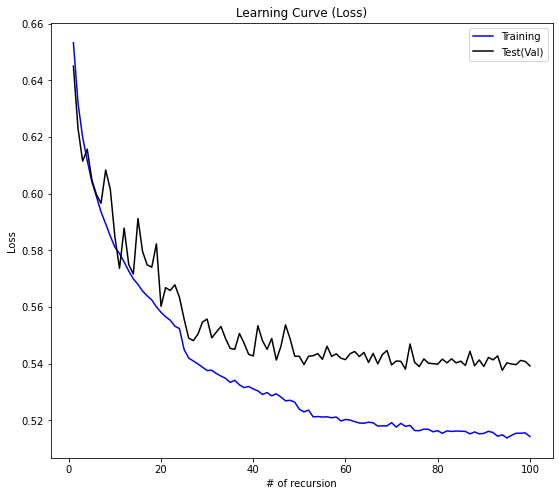

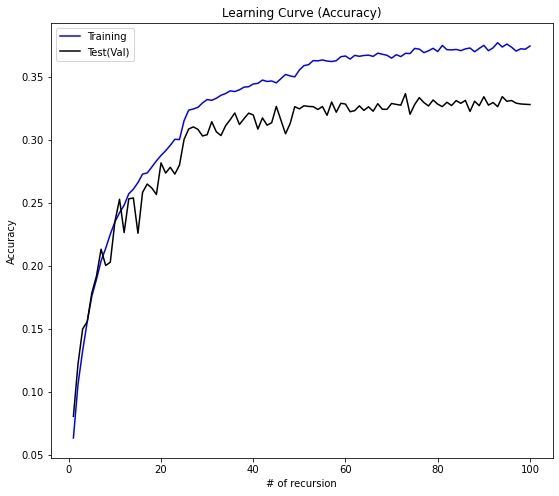

In [23]:
# 評価
evaluate_history(history)

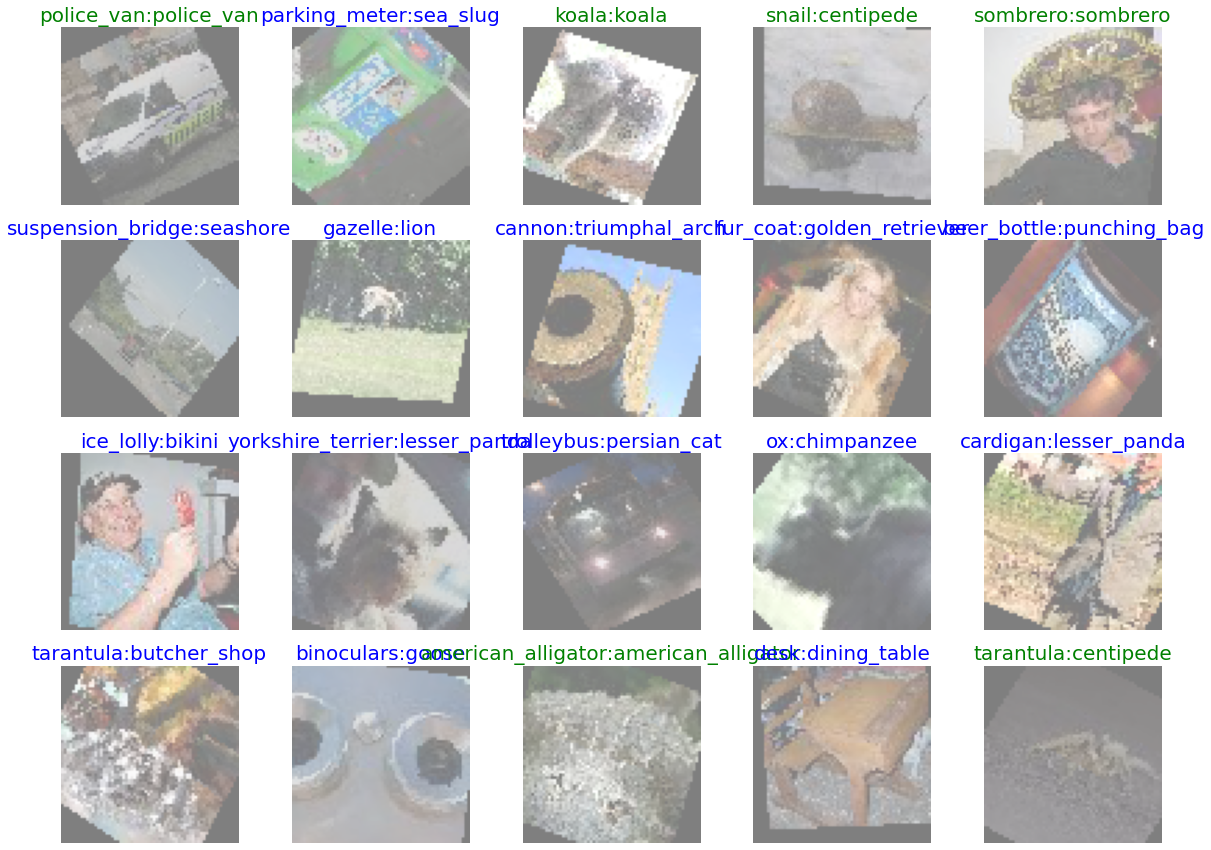

In [34]:
# display images with true label and predicted label
# green titles represent the true label being in the top 5 predicted labels
show_images_labels(val_loader, classes, net, device)

## zero shot learning

In [38]:
# compare base softmax CNN with the combined visual-semantic model
combine_cnn = CNN(n_output, n_hidden)
combine_cnn.load_state_dict(torch.load('devise_bestcnn_cosineembedloss.pth'))

vanilla_cnn = softmax_cnn(n_output, n_hidden)
vanilla_cnn.load_state_dict(torch.load('cnn_best_so_far_40epoch.pth'))

<All keys matched successfully>

In [39]:
# since we are not training we do not need to apply data augmentations
# however CIFAR images do not match the size of tiny-imagenet images so we need to reszie
zero_shot_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [40]:
from torchvision.datasets import CIFAR100

## you can change the directory for downloading cifar-100 data
#data_dir_path_cifar = '/home/yohei/project/cs760/cifar100data/cifar-100-python'
data_dir_path_cifar = 'D:/CIFAR100/cifar-100-python'

train_data_cifar = CIFAR100(download=False,root=data_dir_path_cifar,transform=zero_shot_transform)
train_dl_cifar = DataLoader(train_data_cifar, batch_size=batch_size, shuffle=True)

In [53]:
classes = np.array(classes)
cifar_label = train_data_cifar.classes
cifar_label[0:10]

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle']

In [34]:
cifar_iter = iter(train_dl_cifar)

In [ ]:
for inputs, labels in cifar_iter:
    outputs = combine_cnn(inputs)
    for i, output in enumerate(outputs):
        print('True:',cifar_label[labels[i]])
        pred = pretrain_wv.similar_by_vector(output.detach().numpy(),topn=10)
        print('Pred:',pred)
    print('\n\n')

In [68]:
for inputs, labels in cifar_iter:
    combine_out = combine_cnn(inputs)
    vanilla_out = vanilla_cnn(inputs)
    for i, output in enumerate(outputs):
        vanilla_ind = np.argsort(vanilla_out.detach().numpy()[i])
        print(cifar_label[labels[i]], pretrain_wv.similar_by_vector(output.detach().numpy(),topn=5),classes[vanilla_ind[-5:]])

turtle [('wooden', 0.6220908164978027), ('small', 0.6199623346328735), ('onto', 0.6096287369728088), ('like', 0.6015642285346985), ('one', 0.5985937118530273)] ['snorkel' 'coral_reef' 'sea_cucumber' 'jellyfish' 'dugong']
television [('wooden', 0.588034987449646), ('shaped', 0.5480533838272095), ('plaque', 0.5412776470184326), ('plastic', 0.5271345973014832), ('marble', 0.5258081555366516)] ['space_heater' 'moving_van' 'parking_meter' 'cd_player' 'cash_machine']
ray [('bridge', 0.6565818786621094), ('arches', 0.6507551670074463), ('entrance', 0.6329463720321655), ('arch', 0.6297814846038818), ('wooden', 0.6191951632499695)] ['thatch' 'cliff' 'suspension_bridge' 'seashore' 'barn']
bridge [('book', 0.6980689764022827), ('shop', 0.6445891261100769), ('books', 0.6417549252510071), ('comic', 0.6289997696876526), ('store', 0.6132239699363708)] ['remote_control' 'oboe' 'reel' 'thatch' 'wok']
rocket [('sheep', 0.6473473906517029), ('goat', 0.6468851566314697), ('elephant', 0.6452032327651978), 

possum [('stuffed', 0.620355486869812), ('cat', 0.6189463138580322), ('dog', 0.6175751686096191), ('bag', 0.57990562915802), ('coat', 0.5747660994529724)] ['german_shepherd' 'hog' 'arabian_camel' 'yorkshire_terrier' 'lion']
chimpanzee [('elephant', 0.709121584892273), ('boar', 0.6410366892814636), ('bison', 0.6367425918579102), ('elk', 0.6128488183021545), ('deer', 0.5984594821929932)] ['bison' 'standard_poodle' 'labrador_retriever' 'orangutan' 'chimpanzee']
willow_tree [('cat', 0.7100856304168701), ('dog', 0.6868577599525452), ('elephant', 0.6116547584533691), ('horse', 0.6102131009101868), ('pig', 0.5979555249214172)] ['vestment' 'sock' 'poncho' 'cliff_dwelling' 'cardigan']
porcupine [('seashore', 0.6117241978645325), ('seacoast', 0.6081398725509644), ('shoreline', 0.6020690202713013), ('coastline', 0.586510419845581), ('coastal', 0.5830020904541016)] ['mushroom' 'hog' 'ox' 'bison' 'african_elephant']
man [('elephant', 0.6892856955528259), ('cat', 0.6439290046691895), ('lion', 0.6303

mountain [('wooden', 0.6856840252876282), ('underneath', 0.6208986639976501), ('roof', 0.5999354124069214), ('plastic', 0.5898867249488831), ('beneath', 0.5884923934936523)] ['coral_reef' 'lakeside' 'seashore' 'cliff' 'alp']
possum [('wooden', 0.6057218313217163), ('plastic', 0.6012611985206604), ('oversized', 0.600464940071106), ('shaped', 0.5982086062431335), ('bottle', 0.5801681876182556)] ['ladybug' 'dugong' 'bell_pepper' 'snail' 'acorn']
bus [('cat', 0.6612873077392578), ('elephant', 0.6394863724708557), ('dog', 0.588546633720398), ('lion', 0.5842444896697998), ('bear', 0.582059919834137)] ['standard_poodle' 'ox' 'african_elephant' 'military_uniform' 'koala']
mouse [('oversized', 0.6316064596176147), ('jacket', 0.6312910914421082), ('oversize', 0.6204426884651184), ('cloth', 0.6129198670387268), ('sweater', 0.610226571559906)] ['albatross' 'reel' 'magnetic_compass' 'swimming_trunks' 'snorkel']
lizard [('dog', 0.5641641616821289), ('cat', 0.5440952181816101), ('small', 0.5426501035

poppy [('boar', 0.6891675591468811), ('elephant', 0.6699219346046448), ('bison', 0.6324473023414612), ('elk', 0.6192510724067688), ('lion', 0.6029390096664429)] ['barn' 'dining_table' 'backpack' 'chest' 'sombrero']
turtle [('sweater', 0.6440538167953491), ('jacket', 0.6288795471191406), ('apron', 0.6062703132629395), ('shirt', 0.6020381450653076), ('scarf', 0.5999485850334167)] ['guinea_pig' 'mushroom' 'barrel' 'bell_pepper' 'goldfish']
spider [('lemon', 0.7630999684333801), ('tomato', 0.6992745399475098), ('avocado', 0.6929185390472412), ('lime', 0.6924357414245605), ('sauce', 0.6819959878921509)] ['slug' 'beaker' 'persian_cat' 'hog' 'sea_cucumber']
butterfly [('bridge', 0.7282050848007202), ('viaduct', 0.6841205358505249), ('constructed', 0.6314263939857483), ('roof', 0.614914059638977), ('built', 0.6045043468475342)] ['lion' 'ice_lolly' 'chihuahua' 'golden_retriever' 'yorkshire_terrier']
camel [('cat', 0.6532581448554993), ('dog', 0.652804434299469), ('stuffed', 0.6112421751022339),

baby [('wooden', 0.6388002634048462), ('inside', 0.6364802718162537), ('door', 0.6094658970832825), ('small', 0.6051974892616272), ('used', 0.595922589302063)] ['cardigan' 'miniskirt' 'fur_coat' 'swimming_trunks' 'bikini']
snake [('elephant', 0.6539555788040161), ('cat', 0.6285662055015564), ('lion', 0.6114611625671387), ('snake', 0.6007717847824097), ('monkey', 0.5989851951599121)] ['cliff_dwelling' 'arabian_camel' 'golden_retriever' 'lion'
 'african_elephant']
rocket [('elephant', 0.7148479223251343), ('dog', 0.6475970149040222), ('lion', 0.6464506387710571), ('cat', 0.6419510245323181), ('boar', 0.6395928263664246)] ['snorkel' 'alp' 'swimming_trunks' 'bikini' 'albatross']
rabbit [('bottle', 0.6470784544944763), ('plastic', 0.6467439532279968), ('bag', 0.6343173384666443), ('bucket', 0.6262985467910767), ('tub', 0.5898458957672119)] ['albatross' 'chimpanzee' 'persian_cat' 'baboon' 'hog']
dolphin [('cat', 0.685205340385437), ('elephant', 0.6744229197502136), ('dog', 0.6704314351081848

dolphin [('football', 0.5938060283660889), ('ball', 0.5673965811729431), ('rugby', 0.5512951612472534), ('dog', 0.549425482749939), ('elephant', 0.5399645566940308)] ['jellyfish' 'cougar' 'swimming_trunks' 'dugong' 'snorkel']
telephone [('viaduct', 0.5612146854400635), ('ledge', 0.519996166229248), ('riverbank', 0.5050560832023621), ('jetty', 0.4988856017589569), ('overlooking', 0.49725812673568726)] ['sea_cucumber' 'goose' 'dugong' 'albatross' 'snorkel']
kangaroo [('wooden', 0.6220908164978027), ('small', 0.6199623346328735), ('onto', 0.6096287369728088), ('like', 0.6015642285346985), ('one', 0.5985937118530273)] ['bighorn' 'labrador_retriever' 'cannon' 'german_shepherd' 'ox']
lizard [('wooden', 0.588034987449646), ('shaped', 0.5480533838272095), ('plaque', 0.5412776470184326), ('plastic', 0.5271345973014832), ('marble', 0.5258081555366516)] ['sea_cucumber' 'persian_cat' 'ice_cream' 'brown_bear' 'potpie']
squirrel [('bridge', 0.6565818786621094), ('arches', 0.6507551670074463), ('entr

bowl [('wooden', 0.6255689859390259), ('shaped', 0.589145839214325), ('cat', 0.5883607268333435), ('large', 0.5806291699409485), ('plastic', 0.5792149901390076)] ['lampshade' 'wok' 'wooden_spoon' 'candle' 'dining_table']
orange [('wooden', 0.6352115869522095), ('shaped', 0.6047560572624207), ('plastic', 0.5920398235321045), ('stuffed', 0.5775495171546936), ('oversized', 0.5755226612091064)] ['american_lobster' 'bell_pepper' 'banana' 'lemon' 'orange']
bottle [('elephant', 0.6541736721992493), ('chimpanzee', 0.6488837599754333), ('boar', 0.6263799071311951), ('cat', 0.6150738596916199), ('gorilla', 0.6088910698890686)] ['parking_meter' 'bell_pepper' 'picket_fence' 'walking_stick' 'lakeside']
hamster [('stuffed', 0.620355486869812), ('cat', 0.6189463138580322), ('dog', 0.6175751686096191), ('bag', 0.57990562915802), ('coat', 0.5747660994529724)] ['persian_cat' 'bighorn' 'baboon' 'cougar' 'lion']
chimpanzee [('elephant', 0.709121584892273), ('boar', 0.6410366892814636), ('bison', 0.6367425

KeyboardInterrupt: 